In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import util as u
import pipeline as p
import assess_clf_models as acm
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

### Load Data

In [3]:
if 1 == 1:
    # df0 = u.open_pkl('Data/compound_properties_02_no_dups.pkl')
    df0 = pd.read_csv('Data/compound_properties_02.csv')
    df1 = pd.read_csv('Data/mol_docs_year_syn_res.csv') # num of docs, year-guess, if mol has syn, if mol has res co
    df2 = pd.read_csv('Data/molecule_target_agg_query.csv') # num of targets, target classes, if human_target
    df4 = u.open_pkl('Data/molecule_assays.pkl') # num of activities, num of assays, assay types
    df5 = u.open_pkl('Data/molecule_structure_alerts.pkl') # structural alerts for molecule

    df = pd.merge(df0, df1, how='left', on='molecule_key')
    df = pd.merge(df, df2, how='left', on='molecule_key')
    df = pd.merge(df, df4, how='left', on='molecule_key')
    df = pd.merge(df, df5, how='left', on='molecule_key')
    u.pkl_this('Data/df_merged_01.pkl', df)
    df = u.clean_model_df(df)
    u.pkl_this('Data/model_df_02.pkl', df)

    cols_to_compare = ['mw_freebase', 'alogp', 'acd_logp',
           'acd_logd', 'hba', 'hbd', 'psa', 'rtb', 'ro3_pass',
           'num_ro5_violations', 'acd_most_apka', 'acd_most_bpka',
           'molecular_species', 'aromatic_rings', 'heavy_atoms', 'qed_weighted',
           'hba_lipinski', 'hbd_lipinski', 'num_lipinski_ro5_violations']

    df_no_dups = df.sort_values('num_assays', ascending=False).drop_duplicates(subset=cols_to_compare, keep='first')
    u.pkl_this('Data/model_df_02_no_dups.pkl', df_no_dups)
    df_drop = df[(df['year_impute'].notnull()) | (df['approved'] == 1)]

    cols_to_drop_nas = ['alogp', 'acd_logp', 'acd_logd', 'hba', 'hbd', 'psa', 'rtb', 'ro3_pass',
           'num_ro5_violations', 'molecular_species', 'aromatic_rings', 'heavy_atoms', 'qed_weighted',
           'hba_lipinski', 'hbd_lipinski', 'num_targets', 'num_assays', 'num_activities', 'num_target_organisms']

    df_drop = df_drop.dropna(axis=0, subset=cols_to_drop_nas)
    u.pkl_this('Data/model_df_02_dropped.pkl', df_drop)

else:
    df = u.open_pkl('Data/model_df_02.pkl')
    df_no_dups = u.open_pkl('Data/model_df_02_no_dups.pkl')
    df_drop = u.open_pkl('Data/model_df_02_dropped.pkl')

#### Create "mini" dataset:

In [13]:
size = len(df_drop)
rand_idx = np.random.randint(0, size - 1, size=int(size*0.1))
mini_df = df_drop.loc[rand_idx]
# mini_y = pd.Series([y_train1.iloc[x] for x in rand_idx])
# mini_df.reset_index(inplace=True, drop=True)

## How many drugs enter FDA approval process?

In [4]:
pvcs = df_drop['phase'].value_counts()
pvcs

0    1000777
4       2773
3        597
2        591
1        192
Name: phase, dtype: int64

In [5]:
num_enter_fda = pvcs[1] + pvcs[2] + pvcs[3] + pvcs[4]
num_enter_fda

4153

Date Range:

In [11]:
date_range = df['year_impute'].max() - df['year_impute'].min()
date_range

78.0

In [12]:
num_enter_fda / date_range

53.243589743589745

Approximately 50 small-molecule drugs enter the FDA approval process each year

## Correlation of features

In [14]:
num_col_feats = ['mw_freebase', 'alogp', 'acd_logp', 'acd_logd', 'hba', 'hbd', 'psa', 'rtb', 'ro3_pass',
       'num_ro5_violations', 'aromatic_rings', 'heavy_atoms', 'qed_weighted',
       'hba_lipinski', 'hbd_lipinski', 'research_co', 'num_docs', 'num_targets',  'human_target',
       'num_activities', 'num_assays',  'num_alerts_set1']

test_X = mini_df[num_col_feats]

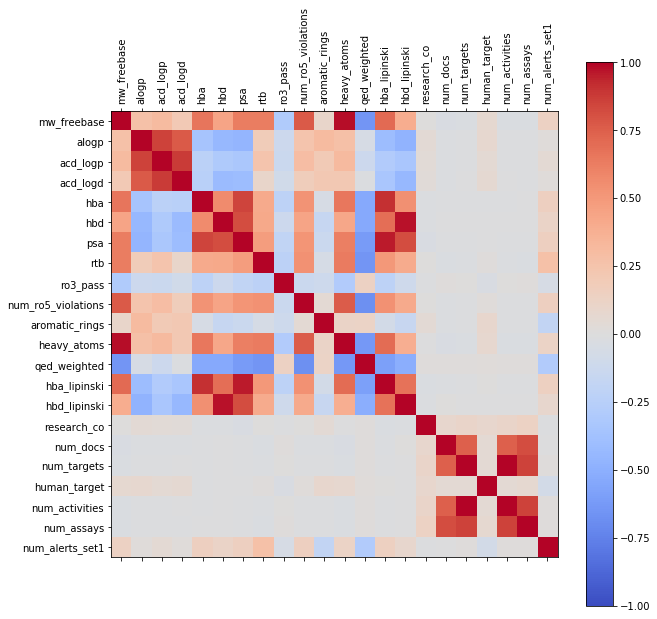

In [15]:
corr = test_X.corr()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(test_X.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(test_X.columns)
ax.set_yticklabels(test_X.columns)
plt.show();

In [19]:
corr.loc['num_targets', 'num_activities']

1.0

Based on this, decided to:
- drop num_docs. Highly correlated with num_targets, num_activities, num_assays
- Engineer:
    - average of num_targets & num_activities. (They are actually the equal (corr=1.0).)
    - ratio of this average : num_assays

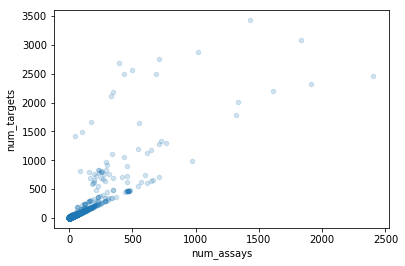

In [20]:
mini_df.plot(x='num_assays', y='num_targets', kind='scatter', alpha=0.2);

In [22]:
avg = mini_df['num_targets'] / mini_df['num_activities']
ratio = avg / mini_df['num_assays']
ratio.describe()

count    53435.000000
mean         0.453119
std          0.344012
min          0.000416
25%          0.166667
50%          0.333333
75%          1.000000
max          1.000000
dtype: float64

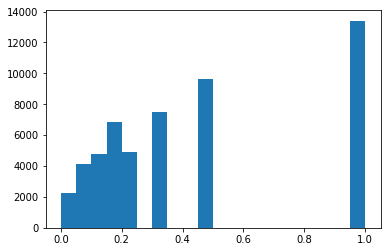

In [24]:
plt.hist(ratio, bins=20);

/Users/kendra/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kendra/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.0204e+04, 3.3174e+04, 0.0000e+00, 0.0000e+00, 1.4800e+02,
        5.7000e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <a list of 10 Patch objects>)

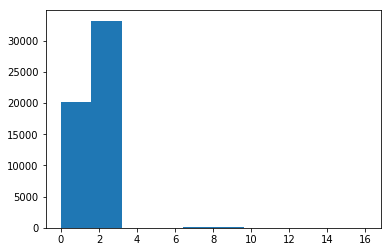

In [28]:
plt.hist(mini_df['aromatic_rings'])

### Year Distribution

In [2]:
import seaborn as sns

In [5]:
entry_year = pd.read_csv('Data/entry_years.csv')

(array([1.60000e+01, 2.50000e+01, 5.70000e+01, 7.90000e+01, 8.90000e+01,
        2.92000e+02, 5.47000e+02, 4.31000e+02, 3.35000e+02, 9.60700e+03,
        2.05400e+04, 2.07990e+04, 2.64780e+04, 4.72760e+04, 5.93030e+04,
        7.13460e+04, 1.06904e+05, 2.07824e+05, 3.08331e+05, 1.95463e+05]),
 array([1939. , 1942.9, 1946.8, 1950.7, 1954.6, 1958.5, 1962.4, 1966.3,
        1970.2, 1974.1, 1978. , 1981.9, 1985.8, 1989.7, 1993.6, 1997.5,
        2001.4, 2005.3, 2009.2, 2013.1, 2017. ]),
 <a list of 20 Patch objects>)

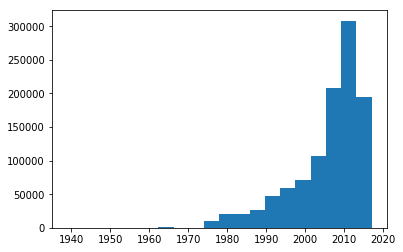

In [12]:
plt.hist(entry_year['year_impute'].dropna(), bins=20)

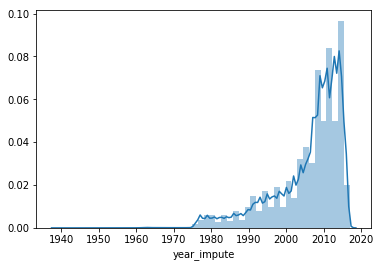

In [9]:
sns.distplot(entry_year['year_impute'].dropna())

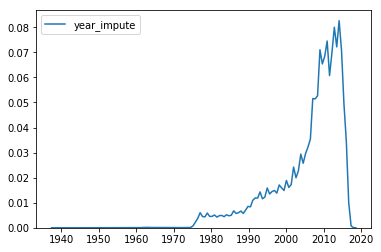

In [10]:
sns.kdeplot(entry_year['year_impute'].dropna())